In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
from scipy.interpolate import interp1d, make_interp_spline
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from typing import Dict, Any, Optional
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy.interpolate import CubicSpline

/Users/bobbytomlinson/Desktop/Coding/School/CS 549/financialTrendForecasting/ftfVenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_stock_data(ticker, start_date, end_date):
    """
    Fetches stock data for a given ticker and date range.

    :param ticker: str, Stock ticker symbol (e.g., 'AAPL' for Apple)
    :param start_date: str, Start date in format 'YYYY-MM-DD'
    :param end_date: str, End date in format 'YYYY-MM-DD'
    :return: pandas DataFrame with stock data
    """
    try:
        # Download the data
        stock_data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
        return stock_data
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [3]:
start_date = "2019-11-11"  # Replace with your desired start date
end_date = "2024-11-11"  # Replace with your desired end date

# Fetch the stock data
aapl_stock_df = get_stock_data('AAPL', start_date, end_date)
jnj_stock_df = get_stock_data('JNJ', start_date, end_date)

aapl_stock_df.columns = aapl_stock_df.columns.get_level_values(0)
jnj_stock_df.columns = jnj_stock_df.columns.get_level_values(0)


# Display the data
if aapl_stock_df is not None:
    print(aapl_stock_df)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price                       Adj Close       Close        High         Low  \
Date                                                                        
2019-11-11 00:00:00+00:00   63.549568   65.550003   65.617500   64.570000   
2019-11-12 00:00:00+00:00   63.491398   65.489998   65.697502   65.230003   
2019-11-13 00:00:00+00:00   64.099754   66.117500   66.195000   65.267502   
2019-11-14 00:00:00+00:00   63.656231   65.660004   66.220001   65.525002   
2019-11-15 00:00:00+00:00   64.412415   66.440002   66.445000   65.752502   
...                               ...         ...         ...         ...   
2024-11-04 00:00:00+00:00  221.766006  222.009995  222.789993  219.710007   
2024-11-05 00:00:00+00:00  223.204422  223.449997  223.949997  221.139999   
2024-11-06 00:00:00+00:00  222.475235  222.720001  226.070007  221.190002   
2024-11-07 00:00:00+00:00  227.229996  227.479996  227.880005  224.570007   
2024-11-08 00:00:00+00:00  226.960007  226.960007  228.660004  226.410004   

In [4]:
aapl_df = aapl_stock_df
jnj_df = jnj_stock_df

print(aapl_df.columns)

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


In [5]:
aapl_df['SMA_20'] = aapl_df['Close'].rolling(window=20).mean()
jnj_df['SMA_20'] = jnj_df['Close'].rolling(window=20).mean()

aapl_df['EMA_20'] = aapl_df['Close'].ewm(span=20, adjust=False).mean()
jnj_df['EMA_20'] = jnj_df['Close'].ewm(span=20, adjust=False).mean()


short_ema = aapl_df['Close'].ewm(span=12, adjust=False).mean()
long_ema = aapl_df['Close'].ewm(span=26, adjust=False).mean()
aapl_df['MACD'] = short_ema - long_ema
aapl_df['Signal_Line'] = aapl_df['MACD'].ewm(span=9, adjust=False).mean()

short_ema = jnj_df['Close'].ewm(span=12, adjust=False).mean()
long_ema = jnj_df['Close'].ewm(span=26, adjust=False).mean()
jnj_df['MACD'] = short_ema - long_ema
jnj_df['Signal_Line'] = jnj_df['MACD'].ewm(span=9, adjust=False).mean()

window = 20
aapl_df['High_20'] = aapl_df['Close'].rolling(window=window).max()
aapl_df['Low_20'] = aapl_df['Close'].rolling(window=window).min()
aapl_df['Fib_23.6'] = aapl_df['Low_20'] + 0.236 * (aapl_df['High_20'] - aapl_df['Low_20'])
aapl_df['Fib_38.2'] = aapl_df['Low_20'] + 0.382 * (aapl_df['High_20'] - aapl_df['Low_20'])
aapl_df['Fib_61.8'] = aapl_df['Low_20'] + 0.618 * (aapl_df['High_20'] - aapl_df['Low_20'])

jnj_df['High_20'] = jnj_df['Close'].rolling(window=window).max()
jnj_df['Low_20'] = jnj_df['Close'].rolling(window=window).min()
jnj_df['Fib_23.6'] = jnj_df['Low_20'] + 0.236 * (jnj_df['High_20'] - jnj_df['Low_20'])
jnj_df['Fib_38.2'] = jnj_df['Low_20'] + 0.382 * (jnj_df['High_20'] - jnj_df['Low_20'])
jnj_df['Fib_61.8'] = jnj_df['Low_20'] + 0.618 * (jnj_df['High_20'] - jnj_df['Low_20'])

low_14 = aapl_df['Close'].rolling(14).min()
high_14 = aapl_df['Close'].rolling(14).max()
aapl_df['%K'] = 100 * ((aapl_df['Close'] - low_14) / (high_14 - low_14))
aapl_df['%D'] = aapl_df['%K'].rolling(3).mean()  # %D is a 3-day SMA of %K


low_14 = jnj_df['Close'].rolling(14).min()
high_14 = jnj_df['Close'].rolling(14).max()
jnj_df['%K'] = 100 * ((jnj_df['Close'] - low_14) / (high_14 - low_14))
jnj_df['%D'] = jnj_df['%K'].rolling(3).mean()  # %D is a 3-day SMA of %K


# Bollinger Bands for AAPL
aapl_df['BB_Mid'] = aapl_df['Close'].rolling(window=20).mean()
aapl_df['BB_Std'] = aapl_df['Close'].rolling(window=20).std()
aapl_df['BB_Upper'] = aapl_df['BB_Mid'] + (aapl_df['BB_Std'] * 2)
aapl_df['BB_Lower'] = aapl_df['BB_Mid'] - (aapl_df['BB_Std'] * 2)

# Bollinger Bands for JNJ
jnj_df['BB_Mid'] = jnj_df['Close'].rolling(window=20).mean()
jnj_df['BB_Std'] = jnj_df['Close'].rolling(window=20).std()
jnj_df['BB_Upper'] = jnj_df['BB_Mid'] + (jnj_df['BB_Std'] * 2)
jnj_df['BB_Lower'] = jnj_df['BB_Mid'] - (jnj_df['BB_Std'] * 2)


# RSI with a window of 14 days
delta = aapl_df['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
aapl_df['RSI'] = 100 - (100 / (1 + rs))

# RSI with a window of 14 days
delta = jnj_df['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
jnj_df['RSI'] = 100 - (100 / (1 + rs))

# Standard Deviation over a window of 20 days
aapl_df['Std_Dev_20'] = aapl_df['Close'].rolling(window=20).std()

# Standard Deviation over a window of 20 days
jnj_df['Std_Dev_20'] = jnj_df['Close'].rolling(window=20).std()


# ichimoku
tenkan_period = 9
kijun_period = 26
senkou_b_period = 52
aapl_df['Tenkan_sen'] = (aapl_df['High'].rolling(window=tenkan_period).max() +
                    aapl_df['Low'].rolling(window=tenkan_period).min()) / 2

# Calculate Kijun-sen (Base Line)
aapl_df['Kijun_sen'] = (aapl_df['High'].rolling(window=kijun_period).max() +
                    aapl_df['Low'].rolling(window=kijun_period).min()) / 2

# Calculate Senkou Span A (Leading Span A)
aapl_df['Senkou_Span_A'] = ((aapl_df['Tenkan_sen'] + aapl_df['Kijun_sen']) / 2).shift(kijun_period)

# Calculate Senkou Span B (Leading Span B)
aapl_df['Senkou_Span_B'] = ((aapl_df['High'].rolling(window=senkou_b_period).max() +
                        aapl_df['Low'].rolling(window=senkou_b_period).min()) / 2).shift(kijun_period)

# Calculate Chikou Span (Lagging Span)
aapl_df['Chikou_Span'] = aapl_df['Close'].shift(-kijun_period)


jnj_df['Tenkan_sen'] = (jnj_df['High'].rolling(window=tenkan_period).max() +
                    jnj_df['Low'].rolling(window=tenkan_period).min()) / 2

# Calculate Kijun-sen (Base Line)
jnj_df['Kijun_sen'] = (jnj_df['High'].rolling(window=kijun_period).max() +
                    jnj_df['Low'].rolling(window=kijun_period).min()) / 2

# Calculate Senkou Span A (Leading Span A)
jnj_df['Senkou_Span_A'] = ((jnj_df['Tenkan_sen'] + jnj_df['Kijun_sen']) / 2).shift(kijun_period)

# Calculate Senkou Span B (Leading Span B)
jnj_df['Senkou_Span_B'] = ((jnj_df['High'].rolling(window=senkou_b_period).max() +
                        jnj_df['Low'].rolling(window=senkou_b_period).min()) / 2).shift(kijun_period)

# Calculate Chikou Span (Lagging Span)
jnj_df['Chikou_Span'] = jnj_df['Close'].shift(-kijun_period)


period = 14
aapl_df['High-Low'] = aapl_df['High'] - aapl_df['Low']
aapl_df['High-Close'] = abs(aapl_df['High'] - aapl_df['Close'].shift(1))
aapl_df['Low-Close'] = abs(aapl_df['Low'] - aapl_df['Close'].shift(1))
aapl_df['TR'] = aapl_df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)

# Calculate +DM and -DM
aapl_df['+DM'] = aapl_df['High'].diff()
aapl_df['-DM'] = aapl_df['Low'].diff()
aapl_df['+DM'] = aapl_df['+DM'].where((aapl_df['+DM'] > aapl_df['-DM']) & (aapl_df['+DM'] > 0), 0)
aapl_df['-DM'] = aapl_df['-DM'].where((aapl_df['-DM'] > aapl_df['+DM']) & (aapl_df['-DM'] > 0), 0)

# Smooth TR, +DM, -DM with Wilder's smoothing
aapl_df['TR_smooth'] = aapl_df['TR'].rolling(window=period).sum()
aapl_df['+DM_smooth'] = aapl_df['+DM'].rolling(window=period).sum()
aapl_df['-DM_smooth'] = aapl_df['-DM'].rolling(window=period).sum()

# Calculate +DI, -DI
aapl_df['+DI'] = 100 * (aapl_df['+DM_smooth'] / aapl_df['TR_smooth'])
aapl_df['-DI'] = 100 * (aapl_df['-DM_smooth'] / aapl_df['TR_smooth'])

# Calculate the DX and ADX
aapl_df['DX'] = 100 * (abs(aapl_df['+DI'] - aapl_df['-DI']) / abs(aapl_df['+DI'] + aapl_df['-DI']))
aapl_df['ADX'] = aapl_df['DX'].rolling(window=period).mean()

# Cleanup intermediate columns
aapl_df.drop(['High-Low', 'High-Close', 'Low-Close', 'TR', '+DM', '-DM', 'TR_smooth', '+DM_smooth', '-DM_smooth', 'DX'], axis=1, inplace=True)


period = 14
jnj_df['High-Low'] = jnj_df['High'] - jnj_df['Low']
jnj_df['High-Close'] = abs(jnj_df['High'] - jnj_df['Close'].shift(1))
jnj_df['Low-Close'] = abs(jnj_df['Low'] - jnj_df['Close'].shift(1))
jnj_df['TR'] = jnj_df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)

# Calculate +DM and -DM
jnj_df['+DM'] = jnj_df['High'].diff()
jnj_df['-DM'] = jnj_df['Low'].diff()
jnj_df['+DM'] = jnj_df['+DM'].where((jnj_df['+DM'] > jnj_df['-DM']) & (jnj_df['+DM'] > 0), 0)
jnj_df['-DM'] = jnj_df['-DM'].where((jnj_df['-DM'] > jnj_df['+DM']) & (jnj_df['-DM'] > 0), 0)

# Smooth TR, +DM, -DM with Wilder's smoothing
jnj_df['TR_smooth'] = jnj_df['TR'].rolling(window=period).sum()
jnj_df['+DM_smooth'] = jnj_df['+DM'].rolling(window=period).sum()
jnj_df['-DM_smooth'] = jnj_df['-DM'].rolling(window=period).sum()

# Calculate +DI, -DI
jnj_df['+DI'] = 100 * (jnj_df['+DM_smooth'] / jnj_df['TR_smooth'])
jnj_df['-DI'] = 100 * (jnj_df['-DM_smooth'] / jnj_df['TR_smooth'])

# Calculate the DX and ADX
jnj_df['DX'] = 100 * (abs(jnj_df['+DI'] - jnj_df['-DI']) / abs(jnj_df['+DI'] + jnj_df['-DI']))
jnj_df['ADX'] = jnj_df['DX'].rolling(window=period).mean()

# Cleanup intermediate columns
jnj_df.drop(['High-Low', 'High-Close', 'Low-Close', 'TR', '+DM', '-DM', 'TR_smooth', '+DM_smooth', '-DM_smooth', 'DX'], axis=1, inplace=True)

In [6]:
aapl_df = aapl_df.reset_index()
jnj_df = jnj_df.reset_index()

print(aapl_df.columns)
print(jnj_df.columns)

Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_20',
       'EMA_20', 'MACD', 'Signal_Line', 'High_20', 'Low_20', 'Fib_23.6',
       'Fib_38.2', 'Fib_61.8', '%K', '%D', 'BB_Mid', 'BB_Std', 'BB_Upper',
       'BB_Lower', 'RSI', 'Std_Dev_20', 'Tenkan_sen', 'Kijun_sen',
       'Senkou_Span_A', 'Senkou_Span_B', 'Chikou_Span', '+DI', '-DI', 'ADX'],
      dtype='object', name='Price')
Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_20',
       'EMA_20', 'MACD', 'Signal_Line', 'High_20', 'Low_20', 'Fib_23.6',
       'Fib_38.2', 'Fib_61.8', '%K', '%D', 'BB_Mid', 'BB_Std', 'BB_Upper',
       'BB_Lower', 'RSI', 'Std_Dev_20', 'Tenkan_sen', 'Kijun_sen',
       'Senkou_Span_A', 'Senkou_Span_B', 'Chikou_Span', '+DI', '-DI', 'ADX'],
      dtype='object', name='Price')


In [7]:
aapl_text = pd.read_csv('../../data/cleaned_AAPL_NEWS.csv')

aapl_text['date'] = pd.to_datetime(aapl_text['date'], errors='coerce', utc=True)
aapl_df['Date'] = pd.to_datetime(aapl_df['Date'], errors='coerce', utc=True)

aapl_text['Date'] = aapl_text['date'].dt.date
aapl_df['Date'] = aapl_df['Date'].dt.date

aapl_text.drop('date',axis=1, inplace=True)

jnj_text = pd.read_csv('../../data/cleaned_JNJ_NEWS.csv')

jnj_text['date'] = pd.to_datetime(jnj_text['date'], errors='coerce', utc=True)
jnj_df['Date'] = pd.to_datetime(jnj_df['Date'], errors='coerce', utc=True)

jnj_text['Date'] = jnj_text['date'].dt.date
jnj_df['Date'] = jnj_df['Date'].dt.date

jnj_text.drop('date',axis=1, inplace=True)

In [8]:
aapl_sec = pd.read_csv('../../data/AAPL_SEC.csv')
aapl_sec['filing_date'] = pd.to_datetime(aapl_sec['filing_date'], errors='coerce', utc=True)
aapl_sec['Date'] = aapl_sec['filing_date'].dt.date
aapl_sec.drop('filing_date', axis=1, inplace=True)

jnj_sec = pd.read_csv('../../data/JNJ_SEC.csv')
jnj_sec['filing_date'] = pd.to_datetime(jnj_sec['filing_date'], errors='coerce', utc=True)
jnj_sec['Date'] = jnj_sec['filing_date'].dt.date
jnj_sec.drop('filing_date', axis=1, inplace=True)

In [9]:
aapl_df_1 = pd.merge(aapl_df, aapl_text, how='left', on='Date')
aapl_df_full = pd.merge(aapl_df_1, aapl_sec, how='left', on='Date')


jnj_df_1 = pd.merge(jnj_df, jnj_text, how='left', on='Date')
jnj_df_full = pd.merge(jnj_df_1, jnj_sec, how='left', on='Date')

In [10]:
print(aapl_df_full.columns)
print(jnj_df_full.columns)

Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_20',
       'EMA_20', 'MACD', 'Signal_Line', 'High_20', 'Low_20', 'Fib_23.6',
       'Fib_38.2', 'Fib_61.8', '%K', '%D', 'BB_Mid', 'BB_Std', 'BB_Upper',
       'BB_Lower', 'RSI', 'Std_Dev_20', 'Tenkan_sen', 'Kijun_sen',
       'Senkou_Span_A', 'Senkou_Span_B', 'Chikou_Span', '+DI', '-DI', 'ADX',
       'Unnamed: 0_x', 'top_5_titles', 'Unnamed: 0_y', 'sec_text'],
      dtype='object')
Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_20',
       'EMA_20', 'MACD', 'Signal_Line', 'High_20', 'Low_20', 'Fib_23.6',
       'Fib_38.2', 'Fib_61.8', '%K', '%D', 'BB_Mid', 'BB_Std', 'BB_Upper',
       'BB_Lower', 'RSI', 'Std_Dev_20', 'Tenkan_sen', 'Kijun_sen',
       'Senkou_Span_A', 'Senkou_Span_B', 'Chikou_Span', '+DI', '-DI', 'ADX',
       'Unnamed: 0_x', 'top_5_titles', 'Unnamed: 0_y', 'sec_text'],
      dtype='object')


In [11]:
aapl_blank_count = aapl_df_full['sec_text'].isna().sum()
aapl_not_blank_count = len(aapl_df_full) - aapl_blank_count
jnj_blank_count = jnj_df_full['sec_text'].isna().sum()
jnj_not_blank_count = len(jnj_df_full) - jnj_blank_count


# Print the breakdown
print("SEC BLANK ENTRIES")
print("AAPL DF:")
print("1. Blank entries:", aapl_blank_count)
print("2. Non-blank entries:", aapl_not_blank_count)
print("")
print("JNJ DF:")
print("1. Blank entries:", jnj_blank_count)
print("2. Non-blank entries:", jnj_not_blank_count)

SEC BLANK ENTRIES
AAPL DF:
1. Blank entries: 1203
2. Non-blank entries: 55

JNJ DF:
1. Blank entries: 1192
2. Non-blank entries: 66


In [12]:
aapl_blank_count = aapl_df_full['top_5_titles'].isna().sum()
aapl_not_blank_count = len(aapl_df_full) - aapl_blank_count
jnj_blank_count = jnj_df_full['top_5_titles'].isna().sum()
jnj_not_blank_count = len(jnj_df_full) - jnj_blank_count


# Print the breakdown
print("NEWS BLANK ENTRIES")
print("AAPL DF:")
print("1. Blank entries:", aapl_blank_count)
print("2. Non-blank entries:", aapl_not_blank_count)
print("")
print("JNJ DF:")
print("1. Blank entries:", jnj_blank_count)
print("2. Non-blank entries:", jnj_not_blank_count)

NEWS BLANK ENTRIES
AAPL DF:
1. Blank entries: 356
2. Non-blank entries: 902

JNJ DF:
1. Blank entries: 197
2. Non-blank entries: 1061


In [13]:
nltk.download('vader_lexicon')
sentiment_analyzer = SentimentIntensityAnalyzer()

def compute_vader_sentiment(text):
    if pd.isnull(text):
        return None
    
    sentiment_scores = sentiment_analyzer.polarity_scores(text)
    compound_score = sentiment_scores['compound']

    return compound_score

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/bobbytomlinson/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [14]:
def time_based_cubic_spline_interpolation(df, date_column, value_column):
    # Ensure the date column is in datetime format
    df[date_column] = pd.to_datetime(df[date_column])
    df = df.sort_values(by=date_column).reset_index(drop=True)
    
    # Create a numeric time index for interpolation
    df['numeric_time'] = (df[date_column] - df[date_column].min()).dt.days

    # Separate known and missing values
    valid_data = df.dropna(subset=[value_column])
    missing_data = df[df[value_column].isna()]

    # Perform cubic spline interpolation if there are enough points
    if len(valid_data) > 2:  # At least 3 points are needed for cubic spline
        spline = CubicSpline(
            valid_data['numeric_time'],  # Time values
            valid_data[value_column]  # Value column
        )
        # Interpolate missing values
        df.loc[missing_data.index, value_column] = spline(missing_data['numeric_time'])

    # Drop the temporary numeric_time column
    df.drop(columns=['numeric_time'], inplace=True)

    # Standardize values to the range [-1, 1]
    min_val = df[value_column].min()
    max_val = df[value_column].max()
    if max_val != min_val:  # Avoid division by zero
        df[value_column] = 2 * (df[value_column] - min_val) / (max_val - min_val) - 1

    # Fill any remaining NaNs with 0 (optional fallback)
    df[value_column] = df[value_column].fillna(0).astype(float)

    return df


def linear_interpolation_if_none(df, date_column, value_column):
    """
    Performs linear interpolation only if the sentiment score is `None`.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing time and sentiment score columns.
        date_column (str): The column with date values.
        value_column (str): The column with sentiment scores to interpolate.

    Returns:
        pd.DataFrame: DataFrame with interpolated values where `None` was present.
    """
    # Ensure the date column is in datetime format
    df[date_column] = pd.to_datetime(df[date_column])
    df = df.sort_values(by=date_column).reset_index(drop=True)

    # Replace "None" with NaN for interpolation
    df[value_column] = df[value_column].apply(lambda x: np.nan if x is None else x)

    # Perform linear interpolation for NaN values
    df[value_column] = df[value_column].interpolate(method='linear', limit_direction='forward')

    return df

In [15]:
aapl_df_full['sec_sentiment_score'] = aapl_df_full['sec_text'].apply(compute_vader_sentiment)
aapl_df_full['news_sentiment_score'] = aapl_df_full['top_5_titles'].apply(compute_vader_sentiment)
aapl_df_full['Date'] = pd.to_datetime(aapl_df_full['Date'])
aapl_df_full = aapl_df_full.sort_values(by="Date").reset_index(drop=True)

aapl_df_full = time_based_cubic_spline_interpolation(aapl_df_full, date_column="Date", value_column="sec_sentiment_score")
aapl_df_full = linear_interpolation_if_none(aapl_df_full, date_column='Date', value_column='news_sentiment_score')

In [16]:
jnj_df_full['sec_sentiment_score'] = jnj_df_full['sec_text'].apply(compute_vader_sentiment)
jnj_df_full['news_sentiment_score'] = jnj_df_full['top_5_titles'].apply(compute_vader_sentiment)
jnj_df_full['Date'] = pd.to_datetime(jnj_df_full['Date'])
jnj_df_full = jnj_df_full.sort_values(by="Date").reset_index(drop=True)

jnj_df_full = time_based_cubic_spline_interpolation(jnj_df_full, date_column="Date", value_column="sec_sentiment_score")
jnj_df_full = linear_interpolation_if_none(jnj_df_full, date_column='Date', value_column='news_sentiment_score')

In [17]:
score_counts = aapl_df_full['sec_sentiment_score'].value_counts()
print("Count of each sentiment score:")
print(score_counts)

Count of each sentiment score:
sec_sentiment_score
0.171059    22
0.184653     3
0.184648     2
0.184222     2
0.184265     2
            ..
0.060387     1
0.057144     1
0.054550     1
0.050444     1
0.307742     1
Name: count, Length: 1231, dtype: int64


In [18]:
# Toolkit

# print(aapl_df_full.columns)
# aapl_df_full.reset_index(inplace=True)
# Linear interpolation


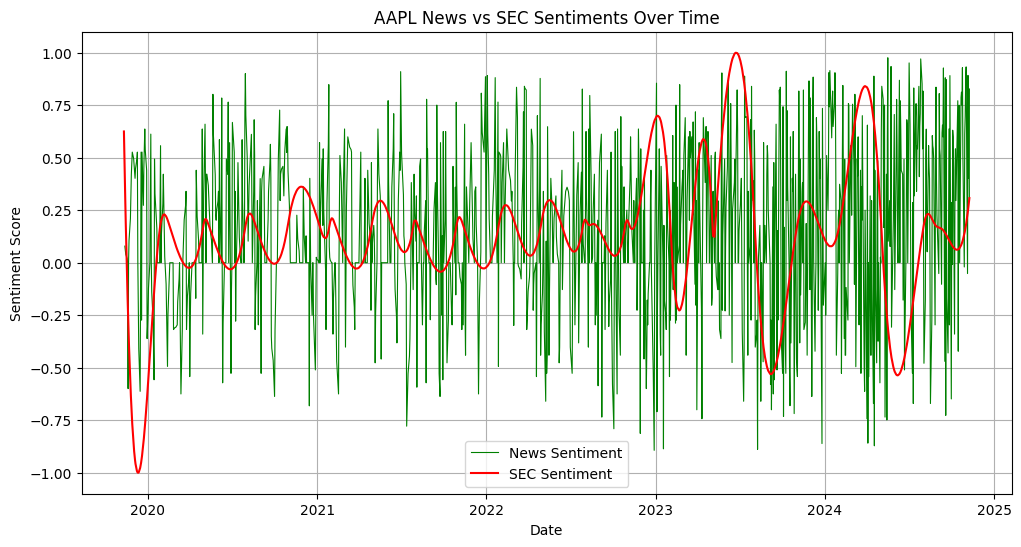

In [19]:
def plot_news_vs_sec_sentiment(df, date_column, news_column, sec_column, title="News vs SEC Sentiments Over Time"):
    """
    Plots news sentiment and SEC sentiment over time on the same axis.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        date_column (str): The column with date values.
        news_column (str): The column with news sentiment scores.
        sec_column (str): The column with SEC sentiment scores.
        title (str): The title of the plot.
    """
    # Ensure the date column is in datetime format
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')

    # Sort the DataFrame by date
    df = df.sort_values(by=date_column).reset_index(drop=True)

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(df[date_column], df[news_column], label="News Sentiment", color="green", linewidth=0.8)
    plt.plot(df[date_column], df[sec_column], label="SEC Sentiment", color="red", linewidth=1.5)

    # Add labels, legend, and grid
    plt.xlabel("Date")
    plt.ylabel("Sentiment Score")
    plt.title(title)
    plt.grid(True)
    plt.legend()

    # Show the plot
    plt.show()

# Compare news vs SEC sentiments for AAPL
plot_news_vs_sec_sentiment(
    aapl_df_full,
    date_column='Date',
    news_column='news_sentiment_score',
    sec_column='sec_sentiment_score',
    title="AAPL News vs SEC Sentiments Over Time"
)


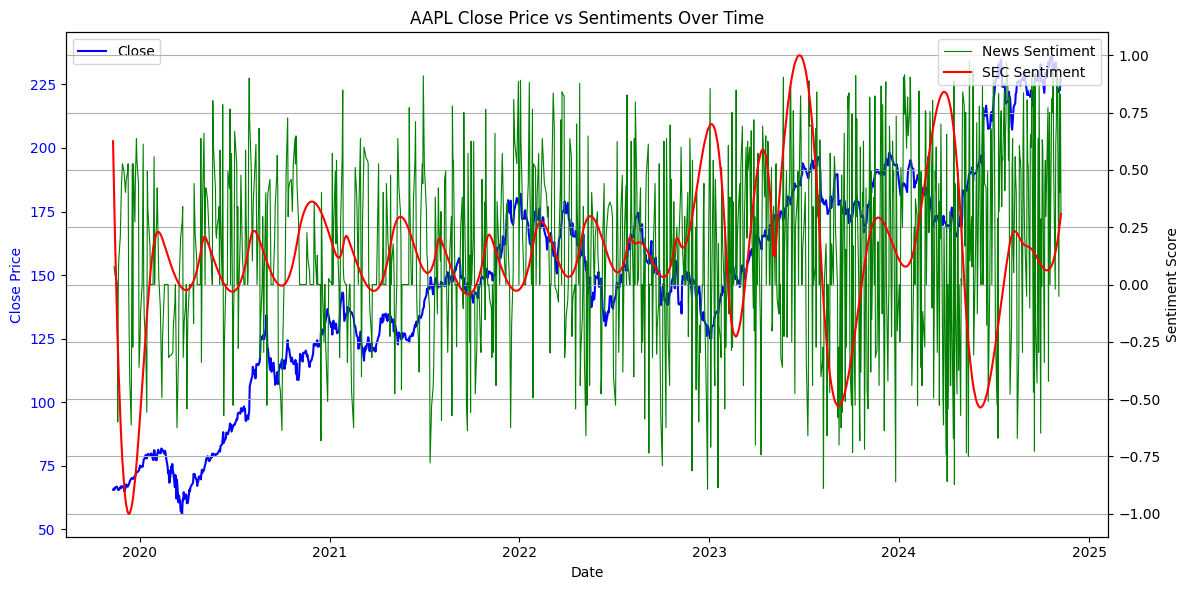

In [20]:
def plot_close_vs_sentiments(df, date_column, close_column, news_column, sec_column, title="Close Price vs Sentiments Over Time"):
    """
    Plots closing price alongside news and SEC sentiment scores with dual y-axes.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        date_column (str): The column with date values.
        close_column (str): The column with closing prices.
        news_column (str): The column with news sentiment scores.
        sec_column (str): The column with SEC sentiment scores.
        title (str): The title of the plot.
    """
    # Ensure the date column is in datetime format
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')

    # Sort the DataFrame by date
    df = df.sort_values(by=date_column).reset_index(drop=True)

    # Create a plot with two y-axes
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot the 'Close' values
    ax1.plot(df[date_column], df[close_column], label='Close', color='blue', linewidth=1.5)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a second y-axis for sentiments
    ax2 = ax1.twinx()
    ax2.plot(df[date_column], df[news_column], label='News Sentiment', color='green', linewidth=0.8)
    ax2.plot(df[date_column], df[sec_column], label='SEC Sentiment', color='red', linewidth=1.5)
    ax2.set_ylabel('Sentiment Score', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Add title, legend, and grid
    plt.title(title)
    fig.tight_layout()
    plt.grid(True)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Show the plot
    plt.show()

# Compare close price with sentiments for AAPL
plot_close_vs_sentiments(
    aapl_df_full,
    date_column='Date',
    close_column='Close',
    news_column='news_sentiment_score',
    sec_column='sec_sentiment_score',
    title="AAPL Close Price vs Sentiments Over Time"
)


In [21]:
def sequential_train_dev_test_split(df, feature_columns, target_column, train_size=0.6, dev_size=0.2):
    """
    Splits the dataset into training, development, and test sets sequentially.

    Parameters:
        df (pd.DataFrame): The full dataset.
        feature_columns (list): List of columns to use as features (X).
        target_column (str): The column to use as the target (Y).
        train_size (float): Proportion of data for training.
        dev_size (float): Proportion of data for development.

    Returns:
        X_train, X_dev, X_test: Feature splits.
        Y_train, Y_dev, Y_test: Target splits.
    """
    # Ensure the dataset is sorted by date
    df = df.sort_values(by='Date').reset_index(drop=True)

    df = df.dropna(subset=feature_columns).reset_index(drop=True)


    # Split indices
    train_end = int(len(df) * train_size)
    dev_end = train_end + int(len(df) * dev_size)

    # Split features (X) and target (Y)
    X = df[feature_columns].set_index(df['Date'])
    y = df[target_column]

    # Sequential train-dev-test split
    X_train, X_dev, X_test = X.iloc[:train_end], X.iloc[train_end:dev_end], X.iloc[dev_end:]
    y_train, y_dev, y_test = y.iloc[:train_end], y.iloc[train_end:dev_end], y.iloc[dev_end:]

    return X_train, X_dev, X_test, y_train, y_dev, y_test

# Define features and target
feature_columns = [
    'Volume', 'SMA_20', 'EMA_20', 'MACD', 'Signal_Line', 'RSI', '%K', '%D',
    'BB_Mid', 'BB_Upper', 'BB_Lower', 'Std_Dev_20', 'Tenkan_sen', 'Kijun_sen',
    'Senkou_Span_A', 'Senkou_Span_B', 'Chikou_Span', '+DI', '-DI', 'ADX',
    'Fib_23.6', 'Fib_38.2', 'Fib_61.8', 'sec_sentiment_score', 'news_sentiment_score'
]
target_column = 'Close'

# Perform the train-dev-test split
aapl_X_train, aapl_X_dev, aapl_X_test, aapl_y_train, aapl_y_dev, aapl_y_test = sequential_train_dev_test_split(
    aapl_df_full, feature_columns, target_column, train_size=0.6, dev_size=0.2
)

jnj_X_train, jnj_X_dev, jnj_X_test, jnj_y_train, jnj_y_dev, jnj_y_test = sequential_train_dev_test_split(
    jnj_df_full, feature_columns, target_column, train_size=0.6, dev_size=0.2
)


# Check the sizes
print("AAPL:")
print(f"X_train: {aapl_X_train.shape}, y_train: {aapl_y_train.shape}")
print(f"X_dev: {aapl_X_dev.shape}, y_dev: {aapl_y_dev.shape}")
print(f"X_test: {aapl_X_test.shape}, y_test: {aapl_y_test.shape}")
print("")
print("JNJ:")
print(f"X_train: {jnj_X_train.shape}, y_train: {jnj_y_train.shape}")
print(f"X_dev: {jnj_X_dev.shape}, y_dev: {jnj_y_dev.shape}")
print(f"X_test: {jnj_X_test.shape}, Y_test: {jnj_y_test.shape}")


AAPL:
X_train: (693, 25), y_train: (693,)
X_dev: (231, 25), y_dev: (231,)
X_test: (231, 25), y_test: (231,)

JNJ:
X_train: (693, 25), y_train: (693,)
X_dev: (231, 25), y_dev: (231,)
X_test: (231, 25), Y_test: (231,)


In [22]:
aapl_X_train.to_csv('../../data/final_input_data/aapl_X_train.csv')
aapl_X_dev.to_csv('../../data/final_input_data/aapl_X_dev.csv')
aapl_X_test.to_csv('../../data/final_input_data/aapl_X_test.csv')
aapl_y_train.to_csv('../../data/final_input_data/aapl_y_train.csv', index='False')
aapl_y_dev.to_csv('../../data/final_input_data/aapl_y_dev.csv', index='False')
aapl_y_test.to_csv('../../data/final_input_data/aapl_y_test.csv', index='False')

jnj_X_train.to_csv('../../data/final_input_data/jnj_X_train.csv')
jnj_X_dev.to_csv('../../data/final_input_data/jnj_X_dev.csv')
jnj_X_test.to_csv('../../data/final_input_data/jnj_X_test.csv')
jnj_y_train.to_csv('../../data/final_input_data/jnj_y_train.csv', index='False')
jnj_y_dev.to_csv('../../data/final_input_data/jnj_y_dev.csv', index='False')
jnj_y_test.to_csv('../../data/final_input_data/jnj_y_test.csv', index='False')